# Skill estimation using graphical models

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import pyGM as gm

### Load the data

In [13]:
def load_data(file_name, pKeep, nEdge, nKeep):
    # Load training data and reduce (subsample) if desired

    # Read thru file to get numeric ids for each player 
    with open(file_name) as f: lines = f.read().split('\n')

    p = 0; playerid = {};
    for i in range(len(lines)):
      csv = lines[i].split(',');
      if len(csv) != 10: continue;   # parse error or blank line
      player0,player1 = csv[1],csv[4];
      if player0 not in playerid: playerid[player0]=p; p+=1;
      if player1 not in playerid: playerid[player1]=p; p+=1;

    nplayers = len(playerid)
    playername = ['']*nplayers
    for player in playerid: playername[ playerid[player] ]=player;  # id to name lookup

    nplays, nwins = np.zeros( (nplayers,nplayers) ), np.zeros( (nplayers,nplayers) );
    for i in range(len(lines)):
      csv = lines[i].split(',');
      if len(csv) != 10: continue;   # parse error or blank line
      a,b = playerid[csv[1]],playerid[csv[4]];
      aw,bw = csv[2]=='[winner]',csv[5]=='[winner]';
      if (np.random.rand() < pKeep):
        if (nplays[a,b] < nKeep) and ( ((nplays[a,:]>0).sum() < nEdge) or ((nplays[:,b]>0).sum() < nEdge) ):
          nplays[a,b] += 1; nplays[b,a]+=1; nwins[a,b] += aw; nwins[b,a] += bw;
        
    print("Fraction of edges to consider: ", pKeep)
    print("Try to keep nEdge_val opponents per player", nEdge)
    print("Keep at most nKeep_val games per opponent pairs", nKeep)
    print("")
    
    return playername, nplayers, nplays, nwins

### A simple list of games & outcomes

In [14]:
def get_games(nplayers, nplays, nwins):
    games = []

    for i in range(nplayers):
        for j in range(nplayers):
            if i == j:
                continue
            if nplays[i, j] > 0:
                for count in range(int(nwins.item(i, j))):
                    game = (i, j, 1)
                    games.append(game)
    return games

### Win probability and graphical model

In [15]:
def get_factors(games, nplayers):
    nlevels = 10   # let's say 10 discrete skill levels
    scale = .3     # this scales how skill difference translates to win probability

    # Make variables for each player; value = skill level
    X = [None]*nplayers
    for i in range(nplayers):
        X[i] = gm.Var(i, nlevels)   

    # Information from each game: what does Pi winning over Pj tell us?
    #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
    Pwin = np.zeros( (nlevels,nlevels) )
    for i in range(nlevels):
        for j in range(nlevels):
            diff = i-j                   # find the advantage of Pi over Pj, then 
            Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

    # before any games, uniform belief over skill levels for each player:
    factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

    # Now add the information from each game:
    for g in games:
        P1,P2,win = g[0],g[1],g[2]
        if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
        factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )
        
    return factors, X, Pwin

### Perform inference to estimate the skill level

In [16]:
def model_inference(model):
    if model.nvar < 0:       # for very small models, we can do brute force inference:
        jt = model.joint()
        jt /= jt.sum()       # normalize the distribution and marginalize the table
        bel = [jt.marginal([i]) for i in range(nplayers)] 
    else:                    # otherwise we need to use some approximate inference:
        from pyGM.messagepass import LBP, NMF
        lnZ,bel = LBP(model, maxIter=10, verbose=True)   # loopy BP
        print("")
        #lnZ,bel = NMF(model, maxIter=10, verbose=True)  # Mean field
    return bel, model

### Compare the ability of the model

In [17]:
def display_ability(bel, X, Pwin, games_val):
    correct = 0
    total = 0
    for game in games_val:
        i,j,outcome = game
        if i<j:
            prob = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
            if prob > 0.50:
                correct += 1
        else:
            prob = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()
            if prob > 0.50:
                correct += 1
        total += 1

    print("Total games played:", total)
    print("Correct estimation:", correct)
    print("Wrong   estimation:", total - correct)
    print("Fraction          : {}%".format(correct / total * 100))
    print("")
    
    return total, correct, (correct / total * 100)

### Display a game outcome

In [18]:
def display_game_prediction(bel, X, Pwin, game, playername):
    i,j,_ = game
    print("Estimated probability {} beats {} next time:".format(playername[i],playername[j]))
    # Expected value (over skill of P0, P1) of Pr[win | P0-P1]
    if i<j:
        prob = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
        print( "Probability: {}".format(prob) )
    else:
        prob = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()
        print( "Probability: {}".format(prob) )

### Sample run

In [19]:
# Sparsifying parameters (discard some training examples):
pKeep = 1.0   # fraction of edges to consider (immed. throw out 1-p edges)
nEdge = 2     # try to keep nEdge_val opponents per player (may be more; asymmetric)
nKeep = 4     # keep at most nKeep_val games per opponent pairs (play each other multiple times)
playername, nplayers, nplays, nwins = load_data('train.csv', pKeep, nEdge, nKeep)

Fraction of edges to consider:  1.0
Try to keep nEdge_val opponents per player 2
Keep at most nKeep_val games per opponent pairs 4



In [20]:
games = get_games(nplayers, nplays, nwins)
factors, X, Pwin = get_factors(games, nplayers)

model = gm.GraphModel(factors)
model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
bel, model = model_inference(model)

Iter 1: 1578.7471775993997
Iter 2: -1439.1295174504025
Iter 3: -1179.7313405651953
Iter 4: -1333.2283720150049
Iter 5: -1353.9085985106835
Iter 6: -1358.9690609058216
Iter 7: -1359.913759868731
Iter 8: -1360.1245830075493
Iter 9: -1360.1647895907342
Iter 10: -1360.1727374245975



In [21]:
nlevels = 10   # let's say 10 discrete skill levels
scale = .8     # this scales how skill difference translates to win probability
# Ranking players by predicted skill
mean_skill_estimates = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

playername_val, nplayers_val, nplays_val, nwins_val = load_data('valid.csv', pKeep = 1.0, nEdge = 3, nKeep = 5)
games_val = get_games(nplayers_val, nplays_val, nwins_val)

Fraction of edges to consider:  1.0
Try to keep nEdge_val opponents per player 3
Keep at most nKeep_val games per opponent pairs 5



In [22]:
total, correct, fraction = display_ability(bel, X, Pwin, games_val)

Total games played: 4696
Correct estimation: 3839
Wrong   estimation: 857
Fraction          : 81.7504258943782%



# 1. Evaluating the required games to accurately predict players' skills:
Decreasing the amount of training data available and observing the performance. Modify the "pKeep" variable to use a different fraction of the training data. To see the effect of the training size on the accuracy, run the experiment for different values of pKeep and observe the changes in the prediction accuracy.

Loading validation data...
Fraction of edges to consider:  1.0
Try to keep nEdge_val opponents per player 3
Keep at most nKeep_val games per opponent pairs 5

Fraction of edges to consider:  0.1
Try to keep nEdge_val opponents per player 3
Keep at most nKeep_val games per opponent pairs 5

Iter 1: 140.34025656626756
Iter 2: -1732.0898707800927
Iter 3: -1890.910018534554
Iter 4: -1982.9655429992185
Iter 5: -2011.5236119991498
Iter 6: -2024.4747592132496
Iter 7: -2029.1259866125542
Iter 8: -2030.962063739257
Iter 9: -2031.6486876992747
Iter 10: -2031.9152050481373

Total games played: 4696
Correct estimation: 3754
Wrong   estimation: 942
Fraction          : 79.94037478705282%

Fraction of edges to consider:  0.25
Try to keep nEdge_val opponents per player 3
Keep at most nKeep_val games per opponent pairs 5

Iter 1: 1149.2121472598046
Iter 2: -2009.0128550836484
Iter 3: -1759.0608354129304
Iter 4: -1980.9605207554832
Iter 5: -2009.598722272472
Iter 6: -2036.2753755669644
Iter 7: -2042.332

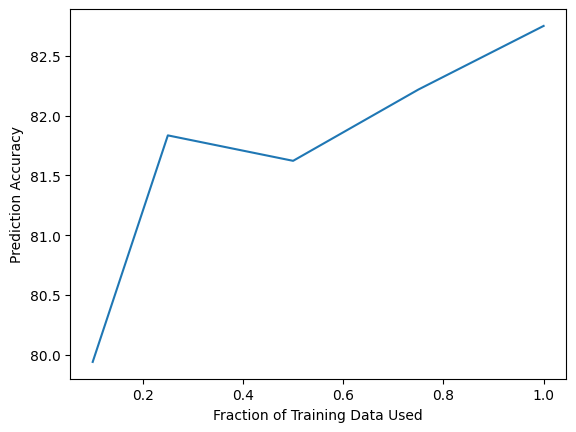

In [8]:
pKeep_values = [0.1, 0.25, 0.5, 0.75, 1.0]
accuracy_results = []

print("Loading validation data...")
playername_val, nplayers_val, nplays_val, nwins_val = load_data('train.csv', pKeep = 1.0, nEdge = 3, nKeep = 5)
games_val = get_games(nplayers_val, nplays_val, nwins_val)

for pKeep in pKeep_values:
    playername, nplayers, nplays, nwins = load_data('valid.csv', pKeep, nEdge = 3, nKeep = 5)
    games = get_games(nplayers, nplays, nwins)
    factors, X, Pwin = get_factors(games, nplayers)

    model = gm.GraphModel(factors)
    model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
    bel, model = model_inference(model)

    nlevels = 10   # let's say 10 discrete skill levels
    scale = .3     # this scales how skill difference translates to win probability
    # Ranking players by predicted skill
    mean_skill_estimates = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

    total, correct, fraction = display_ability(bel, X, Pwin, games_val)
    accuracy_results.append(fraction)

plt.plot(pKeep_values, accuracy_results)
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Prediction Accuracy')
plt.show()

# 2. Evaluating how quickly we can determine a new player's skill:
Add a new player's games gradually into the dataset and observe how their skill estimation accuracy changes. Add a few of the new player's games and re-run the inference, then add a few more games and re-run the inference again, and so on. Monitor how quickly the skill estimation converges.

In [12]:
import random

playername, nplayers, nplays, nwins = load_data('train.csv', pKeep = 1.0, nEdge = 3, nKeep = 5)
games = get_games(nplayers, nplays, nwins)

playerOut = random.randint(2, nplayers-1)  # Choose any player to leave out
print("Excluding the games of player:", playerOut)
print("")
games_without_pOut = [game for game in games if (playerOut not in game)]

games_with_pOut = [game for game in games if (playerOut in game)]

mean_skill_estimates_new_player = []
for i in range(1, len(games_with_pOut) + 1):
    games_subset = games_with_pOut[:i]
    combined_games = games_without_pOut + games_subset
    
    factors, X, Pwin = get_factors(combined_games, nplayers)

    model = gm.GraphModel(factors)
    model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
    bel, model = model_inference(model)
    
    nlevels = 10   # let's say 10 discrete skill levels
    scale = .3     # this scales how skill difference translates to win probability
    # Ranking players by predicted skill
    mean_skill_estimates = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]
    current_skill = mean_skill_estimates[playerOut]
    mean_skill_estimates_new_player.append(current_skill)
    print("Current skill level:", current_skill)
    print("")

Fraction of edges to consider:  1.0
Try to keep nEdge_val opponents per player 3
Keep at most nKeep_val games per opponent pairs 5

Excluding the games of player: 880

Iter 1: 2287.5066304831535
Iter 2: -2667.743474260148
Iter 3: -1831.8300841407336
Iter 4: -2318.9069936148076
Iter 5: -2328.2892087182595
Iter 6: -2346.1886581704616
Iter 7: -2346.7268706003147
Iter 8: -2347.6033976394215
Iter 9: -2347.7157081507676
Iter 10: -2347.7837523647368

Current skill level: 3.8642453937011934

Iter 1: 2288.1112890852146
Iter 2: -2668.443180824916
Iter 3: -1831.761983532215
Iter 4: -2319.202961655366
Iter 5: -2328.6091595460985
Iter 6: -2346.4719701383556
Iter 7: -2347.0161037497505
Iter 8: -2347.8905416787934
Iter 9: -2348.003147672778
Iter 10: -2348.0709856196595

Current skill level: 3.337345827493821

Iter 1: 2290.5817844326875
Iter 2: -2669.2619089704567
Iter 3: -1831.7956164510674
Iter 4: -2319.543406021586
Iter 5: -2328.7904305287725
Iter 6: -2346.6909015785363
Iter 7: -2347.226619987333
I

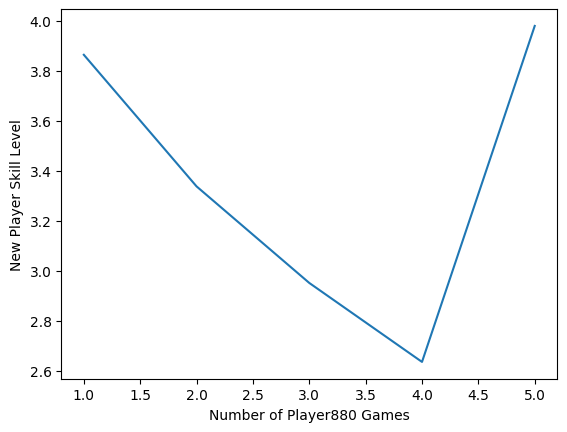

In [13]:
plt.plot(range(1, len(games_with_pOut)+1), mean_skill_estimates_new_player)
plt.xlabel('Number of Player{} Games'.format(playerOut))
plt.ylabel('New Player Skill Level')
plt.show()